# 1K2F G-ADSA Analysis

In this document, we perform the gravimetry-axisymmetric drop shape analysis (G-ADSA) of a sample of a proprietary, difunctional polyol from Dow Chemical with molecular weight ~1000 g/mol in an atmosphere of carbon dioxide. The experiment was performed in the lab of Prof. Ernesto Di Maio in the Department of Chemical Engineering, Materials, and Industrial Production (DICMaPI) at the University of Naples Federico II from June 12-17, 2019.

The analysis computes the **solubility, interfacial tension, diffusivity, and specific volume** of the sample at pressures from 0 to 55 bar at 30.5 C.

We begin by importing the required Python libraries and setting parameters for this particular analysis.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import curve_fit
import dataproc
import errprop

from importlib import reload
reload(dataproc)
reload(errprop)


# SET PARAMETERS
# folder for ADSA data
adsa_folder = '../../EXPERIMENTS/Italy/data/adsa/'
# list of data files for ADSA generated from videos of a pendant drop
adsa_file_list = ['20190613_0614_1k2f_30c_adsa_data.csv', '20190614_0617_1k2f_30c_adsa_data.csv']
# file path for gravimetry data from the Rubotherm machine
grav_file_path = '../../EXPERIMENTS/Italy/data/gravimetry/1k2f_30c-TRD-061219-1804.csv'
# file path to save results
save_folder = '../g-adsa_results/'
save_data_name = '1k2f_30c.csv'
save_plot_name = '1k2f_weight_gas.pdf'
# list of starting times of ADSA data relative to start of gravimetry data
# gravimetry 6/12 6:05:58pm; adsa video 1 6/12 6:16pm, adsa video2 6/14 7:02pm
adsa_t0_list = [3600*25 + 60*8 + 2, 24*3600*2 + 60*56 + 2]
# number of measurements to average for surface tension and volume readings
n_adsa = 10

# weight of sample in atmospheric pressure [g]
w_samp_atm = 0.686
# volume of drop in atmosphere
v_drop_atm = 3.332 
# density of polyol sample from Dow technical data sheet at atmospheric pressure and 25 C (TDS) [g/mL]
rho_samp_atm = 1.02 
# volume of hook and crucible as measured in helium [mL]
v_ref_he = 2.2675 # measured by Maria Rosaria Di Caprio @ 35 C [mL]
diam_cruc = 1.82 # diameter of crucible [cm]

# ordered list of pressure set points (within p_thresh_frac of true values) [kPa]
p_set_arr = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500,
                       5000, 5500, 4650, 3900, 3150, 2400, 1650, 900, 700, 480, 
                       280, 230, 180, 130, 80])
p_thresh_frac = 0.04 # threshold for acceptable difference between actual pressure and set pressure [fraction]
# number of measurements of pressure within equilibrium (300 s, every 30 s)
n_p_eq = 10

# CONSTANTS
# atmospheric pressure [kPa]
P_ATM = 101.3
# mass of crucible and hooks measured June 26 with Rubotherm in atmosphere [g]
TARE = 7.2788 - 0.0003 + dataproc.rho_co2(101.3)*v_ref_he 

## Load Raw Data

Next we load the raw data from gravimetry and ADSA that we wish to process.

In [19]:
# load (and validate) raw data
df, br_arr, bp_arr, p_arr, t_grav, if_tension, v_drop, t_adsa = dataproc.load_raw_data(adsa_folder, adsa_file_list, \
                                                                                      adsa_t0_list, grav_file_path, p_set_arr)
df.head()

,p set [kPa],p actual [kPa],p std [kPa],zero [g],zero std [g],mp1 [g],mp1 std [g],mp2 [g],mp2 std [g],M_0 (extrap) [g],...,dissolved gas balance reading [g],buoyancy correction [g],actual weight of dissolved gas [g],solubility [w/w],solubility error [w/w],specific volume [mL/g],specific volume error [mL/g],diffusivity (sqrt) [cm^2/s],diffusivity (exp) [cm^2/s],diffusion time constant [s]
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Synchronize Gravimetry and ADSA Measurements

In the next section, we synchronize gravimetry and ADSA measurements and identify their corresponding pressures. We then average the final values of the measurements of mass, tare, and interfacial tension (and take the standard deviation as an estimate of the error) and save them for further analysis.

In [20]:
# Identify boundaries of pressure intervals and store gravimetry and ADSA data together after synchronization

# initalize marker for pressure bounds
i_p1 = 0
focus_on_step = False
select_index = 10
plot_p = False
# extract interfacial tension, drop volume, and mass at MP1 for each pressure
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    # get indices of each measurement with pressure within thresholds--I checked and it finds the end within 2 or 3 pts.
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1)
    # take mean and standard deviation of final pressure near equilibrium
    p_eq = p_arr[max(i_p0, i_p1-n_p_eq):i_p1]
    df['p actual [kPa]'].iloc[i] = np.mean(p_eq)
    df['p std [kPa]'].iloc[i] = np.std(p_eq)

    if focus_on_step:
        i_p -= 20
        
        if i != select_index:
            continue
    if plot_p:
        # PLOT PRESSURE TO DEBUG IDENTIFICATION OF PRESSURE STEPS
        plt.figure()
        plt.plot(t_grav[i_p0:i_p1], p_arr[i_p0:i_p1], '.')
        plt.xlabel('time [s]')
        plt.ylabel('pressure [kPa]')
        plt.title('Pressure at set point {0} kPa'.format(p_set))
        if focus_on_step:
            plt.xlim([220000, 250000])
            plt.ylim([4800, 4950])

    # store results in data frame
    df = dataproc.store_grav_adsa(df, i, i_p0, i_p1, t_grav, t_adsa, br_arr, bp_arr, if_tension, v_drop, n_adsa)
    
# correct error in zero measurement at 130 kPa--2 measurements, -0.00218, -0.00217 [g]
df['zero [g]'].loc[23] = -0.002175
df['zero std [g]'].loc[23] = 0.00001

df.head()

Pressure = 0 kPa.
Rejected 1 outliers.


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encount

Interfacial tension = nan mN/m.
Drop volume = nan uL.
Pressure = 500 kPa.
Rejected 1 outliers.
Interfacial tension = 22.887778 mN/m.
Drop volume = 3.370778 uL.
Pressure = 1000 kPa.
Rejected 1 outliers.
Interfacial tension = 21.894000 mN/m.
Drop volume = 3.406100 uL.
Pressure = 1500 kPa.
Rejected 1 outliers.
Interfacial tension = 20.883000 mN/m.
Drop volume = 3.403600 uL.
Pressure = 2000 kPa.
Rejected 1 outliers.
Interfacial tension = 19.825000 mN/m.
Drop volume = 3.494400 uL.
Pressure = 2500 kPa.
Rejected 1 outliers.
Interfacial tension = 18.826000 mN/m.
Drop volume = 3.544700 uL.
Pressure = 3000 kPa.
Rejected 1 outliers.
Interfacial tension = 17.745000 mN/m.
Drop volume = 3.605500 uL.
Pressure = 3500 kPa.
Rejected 1 outliers.
Interfacial tension = 16.378000 mN/m.
Drop volume = 3.676100 uL.
Pressure = 4000 kPa.
Rejected 1 outliers.
Interfacial tension = 15.350000 mN/m.
Drop volume = 3.748200 uL.
Pressure = 4500 kPa.
Rejected 1 outliers.
Interfacial tension = 14.088000 mN/m.
Drop volume

,p set [kPa],p actual [kPa],p std [kPa],zero [g],zero std [g],mp1 [g],mp1 std [g],mp2 [g],mp2 std [g],M_0 (extrap) [g],...,dissolved gas balance reading [g],buoyancy correction [g],actual weight of dissolved gas [g],solubility [w/w],solubility error [w/w],specific volume [mL/g],specific volume error [mL/g],diffusivity (sqrt) [cm^2/s],diffusivity (exp) [cm^2/s],diffusion time constant [s]
0,0,0.1945,0.297129,-7e-05,1e-05,7.96672,1.08972e-05,27.6883,1e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,500,500.046,0,-0.00865,1e-05,7.94209,1e-05,27.6248,1e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000,994.929,1.13687e-13,-0.01748,1e-05,7.9168,1e-05,27.559,1e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1500,1489.97,0.306742,-0.02679,1e-05,7.89008,1e-05,27.4894,1e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,1982.33,0.0576213,-0.03663,1e-05,7.86179,1e-05,27.416,1e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**We see above that the pressure spiked at 5500 kPa, which may explain the kink in the sorption curve that we see below.**
However, in general the pressure remained within about 10 kPa of the average value (which was not necessarily the set value).

## Analysis

Next we perform the analysis of the gravimetry and ADSA data to compute the solubility, diffusivity, and specific volume. We begin with the solubility.

### Interfacial Tension

The interfacial tension measurements are performed using pendant drop analysis with the software FTA32. These results do not require further analysis beyond the averaging and standard deviation performed above.

#### Ad Hoc Estimation of Polymer Mass and Volume under Vacuum

Before estimating the solubility, I must comptue the mass and volume of the polymer under vacuum. For this experiment, I lost the image of the drop under vacuum, so I must estimate the mass and volume of the polyol under vacuum by extrapolating from atmospheric measurements of mass and density. However, since I don't have Rubotherm measurements at atmospheric pressure, I extrapolated the mass between the masses at 80 kPa and 130 kPa. I then estimated the volume by assuming the same mass density as at atmospheric pressure.

In [21]:
# Because I am missing a measurement of the volume of the drop in vacuum, I must estimate
# the mass of the dry polymer in the following ad hoc manner:

# balance readings at equilibrium 
br_eq = df['mp1 [g]'].to_numpy(dtype=float) - df['zero [g]'].to_numpy(dtype=float)
# (extract value at 0 pressure) [g]
br_eq_0 = br_eq[0]
# balance reading for the mass of dissolved gas (must be corrected by buoyancy) [g]
br_gas = br_eq - br_eq_0
df['dissolved gas balance reading [g]'] = br_gas

# sample volume at atmospheric pressure [mL]
v_samp_atm = w_samp_atm / rho_samp_atm
# buoyant force correction at 130 kPa (pressure step at index -2) [g]
w_buoy_130kPa = dataproc.rho_co2(df['p actual [kPa]'].to_numpy(dtype=float)[-2])*(v_samp_atm + v_ref_he)
br_gas_130kPa = br_gas[-2]
# weight of gas at 153 kPa (buoyancy-corrected) [g]
w_gas_130kPa = br_gas_130kPa + w_buoy_130kPa

# buoyant force correction at 80 kPa (pressure step at index -1) [g]
w_buoy_80kPa = dataproc.rho_co2(df['p actual [kPa]'].to_numpy(dtype=float)[-1])*(v_samp_atm + v_ref_he)
br_gas_80kPa = br_gas[-1]
# weight of gas at 80 kPa (buoyancy-corrected) [g]
w_gas_80kPa = br_gas_80kPa + w_buoy_80kPa

# APPROXIMATE weight of gas at atmosphere with linear interpolation [g]
w_gas_atm = w_gas_80kPa + (w_gas_130kPa - w_gas_80kPa)*(P_ATM - 80)/(130 - 80)
# APPROXIMATE weight of polymer by subtracting approximated weight of gas from weight of sample at atmosphere
w_poly_ad_hoc = w_samp_atm - w_gas_atm
print('Dry polymer mass from ad hoc extrap = %3f g vs. mass of polymer at atmospheric pressure = %3f g.' % \
      (w_poly_ad_hoc, w_samp_atm))

# compare result to that obtained by using tare measurement of crucible and hook
w_poly = br_eq_0 - TARE - df['zero [g]'][0]
print("Dry polymer mass estimated using tare measurement = " + str(w_poly) + ' g.')
# APPROXIMATE volume of dry (vacuum) sample using density at atmospheric pressure [mL]
v_poly = w_poly / rho_samp_atm
print('Volume of dry polymer in crucible is approximately ~ %3f mL (using atmospheric density).' % v_poly)

Dry polymer mass from ad hoc extrap = 0.684545 g vs. mass of polymer at atmospheric pressure = 0.686000 g.
Dry polymer mass estimated using tare measurement = 0.6843388451803998 g.
Volume of dry polymer in crucible is approximately ~ 0.670920 mL (using atmospheric density).


### Drop Volume

Below we plot the measurements of the drop volume.

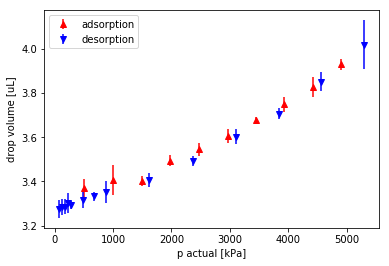

In [22]:
# plot equilibrium drop volume vs. p
fig = plt.figure()
ax = fig.add_subplot(111)
midpt = np.where(p_set_arr == np.max(p_set_arr))[0][0]
ax.errorbar(df['p actual [kPa]'].to_numpy(dtype=float)[:midpt], df['drop volume [uL]'].to_numpy(dtype=float)[:midpt], \
            yerr=df['drop volume std [uL]'].to_numpy(dtype=float)[:midpt], color='r', marker='^', ls='', label='adsorption')
ax.errorbar(df['p actual [kPa]'].to_numpy(dtype=float)[midpt:], df['drop volume [uL]'].to_numpy(dtype=float)[midpt:], \
            yerr=df['drop volume std [uL]'].to_numpy(dtype=float)[midpt:], color='b', marker='v', ls='', label='desorption')
ax.set_xlabel('p actual [kPa]')
ax.set_ylabel('drop volume [uL]')
plt.legend(loc='best')

### Error Propagation

To perform error propagation, we define the following uncertainties, which will be used by subroutines later.

In [26]:
reload(errprop)

# set parameters for error propagation
n = len(p_set_arr[1:])
w_poly_arr = w_poly*np.ones([n])
s_v_drop = df['drop volume std [uL]'].to_numpy(dtype=float)[1:]
s_frac_rho_co2 = 2*df['p std [kPa]'].to_numpy(dtype=float)[1:]/ \
                    df['p actual [kPa]'].to_numpy(dtype=float)[1:]  # fractional uncertainty in density is 2x that of p @ eq
w_samp_ref = w_samp_atm*np.ones([n]) # analytical balance measurement of polyol [g]
s_w_samp_ref = 0.00001*np.ones([n]) # error in analytical balance measurement [g]
rho_samp_ref = rho_samp_atm*np.ones([n]) # [g/mL]
s_rho_samp_ref = 0.01*np.ones([n]) # based on density to 2 decimal places from Dow TDS and small temperature diff (25-->30.5 C) [g/mL]
v_samp_ref = v_samp_atm*np.ones([n]) # [mL]
v_drop_ref = v_drop_eq[-2]*np.ones([n]) # approximation of volume of drop at atmospheric pressure w/ p = 130 kPa [uL]
s_v_drop_ref = s_v_drop[-2]*np.ones([n])
v_ref = v_ref_he*np.ones([n]) # [mL]
s_v_ref = 0.01*np.ones([n]) # estimated error in tare volume using He measurement at 35 C [mL]
s_mp1 = df['mp1 std [g]'].to_numpy(dtype=float)[1:]
s_zero = df['zero std [g]'].to_numpy(dtype=float)[1:]
s_w_gas_ref = 0.00001*np.ones([n]) # ??? [g]

### Solubility

We perform the following calculations based on  to estimate the solubility of CO2 in the polyol sample.

\begin{align*}
    BR_{eq}(p) &= BR_{mp1}(p) - BR_{zero}(p) \\
\end{align*}

where $BR_{eq}(p)$ is the equilibrium balance reading for the mass of the sample, dissolved gas, crucible, and hook at a pressure $p$; $BR_{mp1}$ is the balance reading at measuring point 1 (tare plus sample, dissolved gas, crucible, and hook); and $BR_{zero}$ is the tare value of the balance.

Then the balance reading for the mass of the gas is computed by subtracting the balance reading under vacuum (at which point we assume no gas in the sample),

\begin{align*}
    BR_{gas}(p) &= BR_{eq}(p) - BR_{eq}(p=0) \\
\end{align*}

where $BR_{gas}$ is the balance reading estimate for the mass of the gas, which requires correction by the buoyancy.

The buoyant force correction to mass is the density of the CO2 atmosphere (estimated using equation of state data from NIST) times the volume of the weighed components,

\begin{align*}
    W_{buoy} &= \rho_{CO2}(p)(V_{samp}(p) + V_{ref}) \\
\end{align*}

where $W_{buoy}$ is the buoyant force correction to the weight, $\rho_{CO2}(p)$ is the density of carbon dioxide at pressure $p$ (assuming a temperature of 30.5 C), $V_{samp}(p)$ is the volume of the sample at pressure $p$, which is calculated as $V_{samp}(p) = V_{drop}(p)\frac{V_{samp}(p=p_{atm})}{V_{drop}(p=_{atm})}$, where $V_{drop}(p)$ is the volume of the pendant drop measured by the FTA32 software and $V_{samp}(p=0)$ is determined with the heuristic discussed above in subsection "Ad Hoc Estimation...". $V_{ref}$ is the volume of the crucible and hook, measured in a reference bath of helium at a temperature 35 C by Maria Rosaria Di Caprio to be 2.2675 mL.

Then the true weight of the gas dissolved in the polyol sample is 

\begin{align*}
    W_{gas} &= BR_{gas} + W_{buoy} \\
\end{align*}

and the solubility is calculated as

\begin{align*}
    w_{CO2} &= \frac{W_{gas}}{W_{gas} + W_{poly}} \\
\end{align*}

where $w_{CO2}$ is the weight/weight solubility of CO2 in the polyol sample and $W_{poly}$ is the dry weight of the polyol sample (under vacuum), as estimated above.

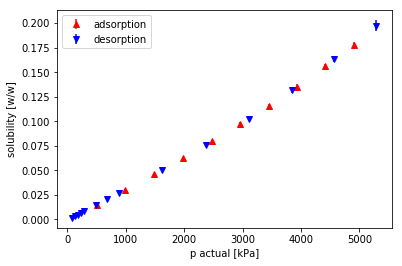

In [27]:
# COMPUTE AND PLOT SOLUBILITY

# Drop volume [uL]
v_drop_eq = df['drop volume [uL]'].to_numpy(dtype=float)
# Use fractional change in drop volume from atmospheric pressure to estimate sample volume
v_samp = v_drop_eq / v_drop_atm * v_samp_atm
df['sample volume [mL]'] = v_samp

# calculate "actual gas weight gain" with buoyancy correction; volumes in mL, density in g/mL
w_buoy = dataproc.rho_co2(df['p actual [kPa]'].to_numpy(dtype=float))*(v_samp + v_ref_he)
df['buoyancy correction [g]'] = w_buoy
w_gas_act = br_gas + w_buoy
df['actual weight of dissolved gas [g]'] = w_gas_act
# calculate solubility w/w
solubility = w_gas_act / (w_poly + w_gas_act)
df['solubility [w/w]'] = solubility

# set parameters for error propagation
n = len(p_set_arr[1:])
spec_vol = df['specific volume [mL/g]'].to_numpy(dtype=float)[1:]
s_v_drop = df['drop volume std [uL]'].to_numpy(dtype=float)[1:]
s_frac_rho_co2 = 2*df['p std [kPa]'].to_numpy(dtype=float)[1:]/ \
                    df['p actual [kPa]'].to_numpy(dtype=float)[1:]  # fractional uncertainty in density is 2x that of p @ eq
w_samp_ref = w_samp_atm*np.ones([n]) # analytical balance measurement of polyol [g]
s_w_samp_ref = 0.00001*np.ones([n]) # error in analytical balance measurement [g]
rho_samp_ref = rho_samp_atm*np.ones([n]) # [g/mL]
s_rho_samp_ref = 0.01*np.ones([n]) # based on density to 2 decimal places from Dow TDS and small temperature diff (25-->30.5 C) [g/mL]
v_samp_ref = v_samp_atm*np.ones([n]) # [mL]
v_drop_ref = v_drop_eq[-2]*np.ones([n]) # approximation of volume of drop at atmospheric pressure w/ p = 130 kPa [uL]
s_v_drop_ref = s_v_drop[-2]*np.ones([n])
v_ref = v_ref_he*np.ones([n]) # [mL]
s_v_ref = 0.01*np.ones([n]) # estimated error in tare volume using He measurement at 35 C [mL]
s_mp1 = df['mp1 std [g]'].to_numpy(dtype=float)[1:]
s_zero = df['zero std [g]'].to_numpy(dtype=float)[1:]
s_w_gas_ref = 0.00001*np.ones([n]) # ??? [g]

# propagate the error in the solubility
s_solubility = errprop.error_solubility(solubility[1:], v_samp[1:], w_buoy[1:], w_gas_act[1:], v_drop_eq[1:], 
                                    s_v_drop,  w_poly_arr, s_frac_rho_co2, w_samp_ref, s_w_samp_ref,
                                    rho_samp_ref, s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                    v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
s_solubility = np.concatenate((np.array([np.nan]), s_solubility))
df['solubility error [w/w]'] = s_solubility

# plot solubility vs. p
fig = plt.figure()
ax = fig.add_subplot(111)
midpt = np.where(p_set_arr == np.max(p_set_arr))[0][0]
ax.errorbar(df['p actual [kPa]'].to_numpy(dtype=float)[:midpt], solubility[:midpt], \
            yerr=s_solubility[:midpt], color='r', marker='^', ls='', label='adsorption')
ax.errorbar(df['p actual [kPa]'].to_numpy(dtype=float)[midpt:], solubility[midpt:], \
            yerr=s_solubility[midpt:], color='b', marker='v', ls='', label='desorption')
ax.set_xlabel('p actual [kPa]')
ax.set_ylabel('solubility [w/w]')
plt.legend(loc='best')

### Specific Volume

The specific volume is calculated as

\begin{align*}
    v(p) &= \frac{V_{samp}(p)}{W_{gas} + W_{poly}} \\
\end{align*}

for which we have already calculated the necessary values.

(0.9, 1)

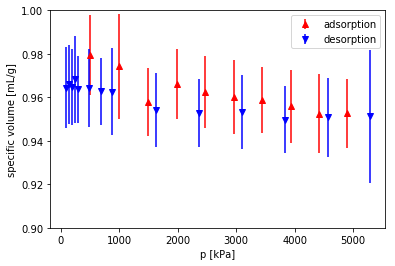

In [31]:
reload(errprop)

# calculate specific volume
spec_vol = v_samp / (w_gas_act + w_poly)
df['specific volume [mL/g]'] = spec_vol

# propagate error to estimate uncertainty
s_spec_vol = errprop.error_spec_vol(spec_vol[1:], v_samp[1:], w_buoy[1:], w_gas_act[1:], v_drop_eq[1:], 
                                    s_v_drop,  w_poly_arr, s_frac_rho_co2, w_samp_ref, s_w_samp_ref,
                                    rho_samp_ref, s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                    v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
s_spec_vol = np.concatenate((np.array([np.nan]), s_spec_vol))
df['specific volume error [mL/g]'] = s_spec_vol

# save results
df.to_csv(save_folder + save_data_name)

# Plot specific volume vs. pressure
fig = plt.figure()
ax = fig.add_subplot(111)
midpt = np.where(p_set_arr == np.max(p_set_arr))[0][0]
ax.errorbar(df['p actual [kPa]'].to_numpy(dtype=float)[:midpt], spec_vol[:midpt],
            yerr=s_spec_vol[:midpt], color='r', marker='^', ls='', label='adsorption')
ax.errorbar(df['p actual [kPa]'].to_numpy(dtype=float)[midpt:], spec_vol[midpt:],
            yerr=s_spec_vol[midpt:], color='b', marker='v', ls='', label='desorption')
ax.set_xlabel('p [kPa]')
ax.set_ylabel('specific volume [mL/g]')
plt.legend(loc='best')
ax.set_ylim([0.9,1])

#### Plotting mass of absorbed gas over time

For visual analysis, we plot the absorption of gas over time alongside the pressure

Pressure = 0 kPa.
Rejected 1 outliers.
Pressure = 500 kPa.
Rejected 1 outliers.
Pressure = 1000 kPa.
Rejected 1 outliers.
Pressure = 1500 kPa.
Rejected 1 outliers.
Pressure = 2000 kPa.
Rejected 1 outliers.
Pressure = 2500 kPa.
Rejected 1 outliers.
Pressure = 3000 kPa.
Rejected 1 outliers.
Pressure = 3500 kPa.
Rejected 1 outliers.
Pressure = 4000 kPa.
Rejected 1 outliers.
Pressure = 4500 kPa.
Rejected 1 outliers.
Pressure = 5000 kPa.
Rejected 1 outliers.
Pressure = 5500 kPa.
Rejected 1 outliers.
Pressure = 4650 kPa.
Rejected 1 outliers.
Pressure = 3900 kPa.
Rejected 1 outliers.
Pressure = 3150 kPa.
Rejected 1 outliers.
Pressure = 2400 kPa.
Rejected 1 outliers.
Pressure = 1650 kPa.
Rejected 1 outliers.
Pressure = 900 kPa.
Rejected 1 outliers.
Pressure = 700 kPa.
Rejected 1 outliers.
Pressure = 480 kPa.
Rejected 1 outliers.
Pressure = 280 kPa.
Rejected 1 outliers.
Pressure = 230 kPa.
Rejected 1 outliers.
Pressure = 180 kPa.
Rejected 1 outliers.
Pressure = 130 kPa.
Rejected 1 outliers.
Pre

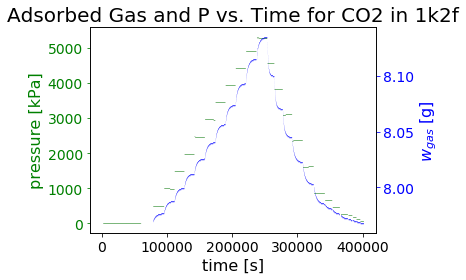

In [32]:
from scipy.signal import medfilt

# Set plot parameters
lw = 2
ax_fs = 16
t_fs = 20
tk_fs = 14
colors = ['g', 'b']
line_styles = ['--',  '-']
ms = 0.005
x_lim = [80000, 400000]
y_lim = [7.88, 7.9]

# initalize marker for pressure bounds
i_p1 = 0
# initialize array to store p, t, and gas weight for plotting
w_gas_2_plot = np.array([])
p_2_plot = np.array([])
t_2_plot = np.array([])
# initialize mass of gas from end of previous pressure step as initial mass M_0 [g]
M_0_prev = np.zeros([len(p_set_arr)])
# initialize array of mass of gas at equilibrium using last mass of current pressure step [g]
M_infty_final = np.zeros([len(p_set_arr)])
# extract interfacial tension, drop volume, and mass at MP1 for each pressure
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    # get indices of each measurement with pressure within thresholds 
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1)
    # extract data for current pressure
    t_select = t_grav[i_p0:i_p1]
    br_select = br_arr[i_p0:i_p1]
    bp_select = bp_arr[i_p0:i_p1]
    p_select = p_arr[i_p0:i_p1]
    
    # extract mp1 measurements and corresponding times for the current pressure set point
    is_mp1 = (bp_select == 2)
    mp1 = medfilt(br_select[is_mp1], kernel_size=5) # medfilt removes spikes from unstable measurements
    t_mp1 = t_select[is_mp1]
    p_mp1 = p_select[is_mp1]
    # Is the sample adsorbing or desorbing gas?
    is_adsorbing = (p_set_arr[i] - p_set_arr[max(i-1,0)]) >= 0
    # Cut off data points at the beginning and end from the transition between pressure set points
    i_start, i_end = dataproc.get_mp1_interval(mp1, is_adsorbing)
    mp1 = mp1[i_start:i_end]
    t_mp1 = t_mp1[i_start:i_end]
    p_mp1 = p_mp1[i_start:i_end]

    # compute mass of adsorbed gas and append
    zero = df['zero [g]'].iloc[i]
    w_buoy = df['buoyancy correction [g]'].iloc[i]
    # compute actual gas mass by subtracting zero (tare) and correcting for buoyancy
    w_gas_act_curr = mp1 - zero + w_buoy
    
    # save gas mass from current run for next M_0
    w_gas_act_f = np.mean(w_gas_act_curr[:-n_p_eq])
    if i < len(p_set_arr)-1:
        M_0_prev[i+1] = w_gas_act_f
    # save gas mass from current run for current M_infty
    M_infty_final[i] = w_gas_act_f
    
    # skip if data has nans
    if np.isnan(w_gas_act_curr.any()):
        continue
        
    # append data for plotting
    w_gas_2_plot = np.append(w_gas_2_plot, w_gas_act_curr)
    p_2_plot = np.append(p_2_plot, p_mp1)
    t_2_plot = np.append(t_2_plot, t_mp1)

# save initial mass estimated using previous gas mass [g]
df['M_0 (prev) [g]'] = M_0_prev
# save final gas mass [g]
df['M_infty (final) [g]'] = M_infty_final

# Plot adsorbed gas and pressure over time
# create plot for pressure
fig, ax1 = plt.subplots()
# plot pressure
ax1.plot(t_2_plot, p_2_plot, 'o', ms=ms, label='p', color=colors[0])
# labels
ax1.set_xlabel('time [s]', fontsize=ax_fs)
ax1.set_ylabel('pressure [kPa]', color=colors[0], fontsize=ax_fs)
ax1.tick_params('y', colors=colors[0])
ax1.set_title('Adsorbed Gas and P vs. Time for CO2 in 1k2f', fontsize=t_fs)

# separate axis for gas mass
ax2 = ax1.twinx()
# plot adsorbed gas mass
ax2.plot(t_2_plot, w_gas_2_plot, '^', ms=ms, label=r'$w_{gas}$', color=colors[1])
# labels
ax2.set_ylabel(r'$w_{gas}$ [g]', color=colors[1], fontsize=ax_fs)
ax2.tick_params('y', colors=colors[1])
# limits
# ax2.set_ylim(y_lim)
# ax2.set_xlim(x_lim)

# increase font size of tick labels
ax1.tick_params(axis='both', which='major', labelsize=tk_fs)
ax2.tick_params(axis='y', which='major', labelsize=tk_fs)
fig.tight_layout()

# save plot ?
if len(save_plot_name) > 0 :
    plt.savefig(save_folder + save_plot_name, bbox_inches="tight")

### Diffusivity

Because the diffusivity changes with the concentration of CO2 in the polyol, and because the concentration of CO2 in the polyol changes substantially during the course of sorption at a single pressure, we cannot justify the assumption that the diffusivity $D$ is constant throughout the sample or throughout the course of sorption. Instead, we must use models that account for a varying diffusivity, as derived by Crank in *The Mathematics of Diffusion* (1956).

#### Model 1: Use Initial Gradient (eqn. 6 in Pastore et al. 2011; eqn. 7 in Vrentas et al. 1977)

For a constant diffusion coefficient $D$ of a gas diffusing into a sheet of thickness $l$ open to atmosphere on both sides, Crank derives in sect 4.3.2 p. 48 that

\begin{align}
\frac{M_t}{M_{\infty}} &= \frac{4}{\pi^{1/2}}\left(\frac{Dt}{l^2}\right)^{1/2} \\
\end{align}

At the start of diffusion, the diffusion coefficient is constant as diffusion almost exclusively occurs within a thin skin layer along the interface between sample and gas. Somehow (***I don't understand this***), this means that the average diffusion coefficient $\bar{D}$ can be approximated by taking the derivative of the above equation with respect to the square-root of time over the sample thickness squared at the beginning of the experiment ($t = t_0$). Thus,

\begin{align*}
\bar{D} &= \frac{\pi}{16}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t/l^2}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

In this experiment, however, the sample is only open to the atmosphere on one side; on the other, there is no flux, so the boundary condition is $\frac{\partial c}{\partial z} = 0$ (where $c$ is the concentration of the gas and $z$ is the direction of diffusion perpendicular to the surface of the sample), which is mathematically identical to the symmetry condition in the system considered by Crank at the center of the sample. Thus, the present system can be mapped onto that of Crank by simply replacing $l$ (the thickness of the sample exposed to gas on two sides) with $2h_{samp}$ (where $h_{samp}$ is the thickness of the sample in the sorption experiment exposed to gas on one side). Thus,

\begin{align*}
\bar{D} &= \frac{\pi h_{samp}^2}{4}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

According to the first equation in this cell (10.165 in Crank's textbook), the mass of the sample will initially increase as $t^{1/2}$, so we fit the sample weight at the beginning of sorption to the equation 

\begin{align*}
W_{gas}^{act} &= a \sqrt{t-t_0^{fit}} + b\\
\end{align*}

with fitting parameters $a$, $t_0^{fit}$, and $b$.

$M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ (the dry mass of the polymer under vacuum) is constant, the time derivatives of the gas mass and the total mass are the same. Therefore, at $t = t_0^{fit}$,

\begin{align*}
\left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}W_{gas}^{act}\right|_{t=t_0^{fit}} &= \left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}\left(a \sqrt{t-t_0^{fit}} + b\right)\right|_{t=t_0^{fit}}\\
\left.\frac{\mathrm{d}M_t}{\mathrm{d}\sqrt{t}}\right|_{t=t_0^{fit}} &= a \\
\end{align*}

We can then use the above equation relating the time derivative of the sample mass at the initial time of sorption/desorption $t_0^{fit}$ to the average diffusion constant,

\begin{align*}
\sqrt{M_{\infty}^2\bar{D} \frac{4}{\pi h_{samp}^2}} &= a\\
\bar{D} &= \left(\frac{\pi h_{samp}^2}{4}\right)\left(\frac{a}{M_{\infty}}\right)^2 \\
\end{align*}

As a result, the only remaining parameter to estimate is $M_{\infty}$, the equilibrium mass of the sample. Scaling analysis (***ADD LATER***) shows that at late times the sample mass approaches the equilibrium mass exponentially. Thus, to estimate the equilibrium mass, we fit an exponential curve of the following form to the late-time data points,

\begin{align*}
W_{gas}^{act} &= A e^{Bt} + M_{\infty}\\
\end{align*}

where $A$, $B$, and $M_{\infty}$ are fitting parameters. We then use the fitted value for $M_{\infty}$ and estimate the average diffusion coefficient $\bar{D}$ with the equation above.

Pressure = 0 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t min = 81.425 and t max = 16611.425
w min = 0.001 and w max = 0.008
D_sqrt = 4.15e-07 cm^2/s.
t_init = 78510
t0_fit = 78458.57524538752
t0 = 59820
Pressure = 1000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t min = 140.792 and t max = 15710.792
w min = 0.002 and w max = 0.012
D_sqrt = 2.68e-07 cm^2/s.
t_init = 95370
t0_fit = 95319.2075329326
t0 = 95130
Pressure = 1500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t min = 162.575 and t max = 14832.575
w min = 0.002 and w max = 0.013
D_sqrt = 1.57e-07 cm^2/s.
t_init = 111360
t0_fit = 111287.42465745033
t0 = 111090
Pressure = 2000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.


C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


t min = 178.568 and t max = 15118.568
w min = 0.002 and w max = 0.014
D_sqrt = 1.06e-07 cm^2/s.
t_init = 126480
t0_fit = 126391.43236933564
t0 = 126180
Pressure = 2500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t min = 137.837 and t max = 15707.837
w min = 0.002 and w max = 0.015
D_sqrt = 7.63e-08 cm^2/s.
t_init = 141870
t0_fit = 141822.16268346258
t0 = 141570
Pressure = 3000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t min = 158038.678 and t max = 173578.678
w min = 1.142 and w max = 1.156
D_sqrt = 1.31e-05 cm^2/s.
t_init = 157890
t0_fit = -58.67799646129969
t0 = 157590
Pressure = 3500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t min = 174136.936 and t max = 189076.936
w min = 1.364 and w max = 1.378
D_sqrt = 1.21e-05 cm^2/s.
t_init = 174000
t0_fit = -16.936377945263718
t0 = 173580
Pressure = 4000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t min = 80.793 and t max = 15050.793
w min = 0.002 and w max = 0.019
D_sqrt = 4.52e-08 cm^2/s.
t_init = 189420
t0_fit = 189459.2068

C:\Users\Andy.DESKTOP-CFRG05F\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\g-adsa\dataproc.py:421: RuntimeWarning: invalid value encountered in sqrt
  v_drop, n_adsa, w_resolution=1E-5):


D_sqrt = 1.42e-05 cm^2/s.
t_init = 237300
t0_fit = -3493.347047255227
t0 = 236610
Pressure = 4650 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t min = 134.203 and t max = 10304.203
w min = 0.009 and w max = 0.037
D_sqrt = 3.73e-07 cm^2/s.
t_init = 253590
t0_fit = 253575.7972973403
t0 = 253260
Pressure = 3900 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t min = 264948.707 and t max = 277338.707
w min = 5.826 and w max = 5.852
D_sqrt = 1.48e-04 cm^2/s.
t_init = 264300
t0_fit = -528.7071404062697
t0 = 264030
Pressure = 3150 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t min = 277706.047 and t max = 291656.047
w min = 4.479 and w max = 4.503
D_sqrt = 1.39e-04 cm^2/s.
t_init = 277230
t0_fit = -446.04727851710675
t0 = 276930
Pressure = 2400 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t min = 120.831 and t max = 15870.831
w min = 0.004 and w max = 0.025
D_sqrt = 3.61e-07 cm^2/s.
t_init = 291630
t0_fit = 291539.16880974
t0 = 291330
Pressure = 1650 kPa.
Rejected 1 outliers.
Rejected 1 

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


t min = 430.389 and t max = 5410.389
w min = 0.000 and w max = 0.001
D_sqrt = 2.04e-07 cm^2/s.
t_init = 384690
t0_fit = 384289.6112246568
t0 = 383520
Pressure = 130 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t min = 390308.533 and t max = 395888.533
w min = 0.236 and w max = 0.237
D_sqrt = 1.96e-04 cm^2/s.
t_init = 390000
t0_fit = -278.53260739554486
t0 = 389850
Pressure = 80 kPa.
t min = 395608.193 and t max = 400828.193
w min = 0.225 and w max = 0.226
D_sqrt = 5.12e-04 cm^2/s.
t_init = 395910
t0_fit = 391.80711119740084
t0 = 395760


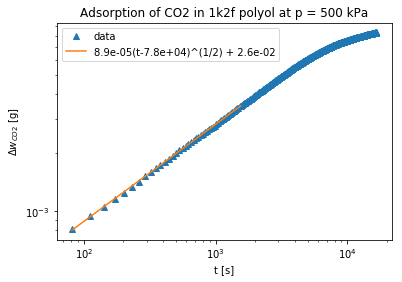

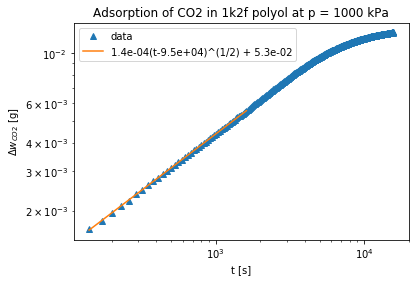

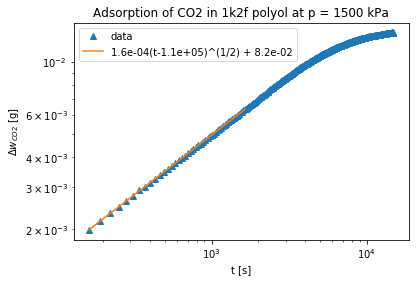

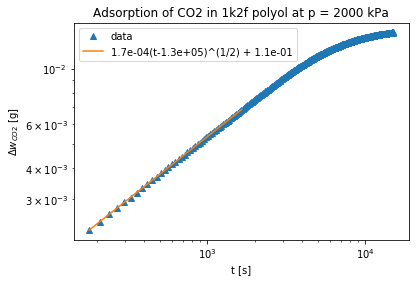

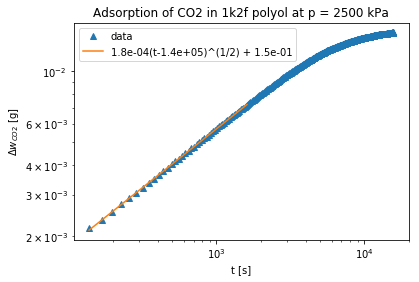

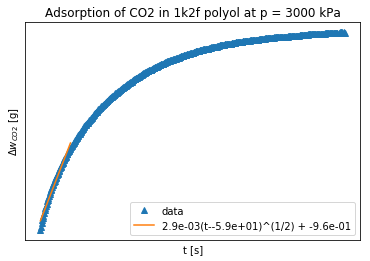

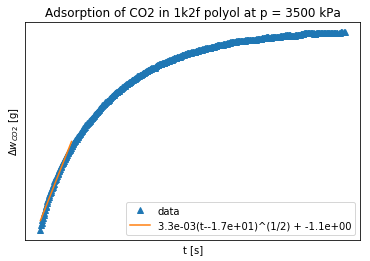

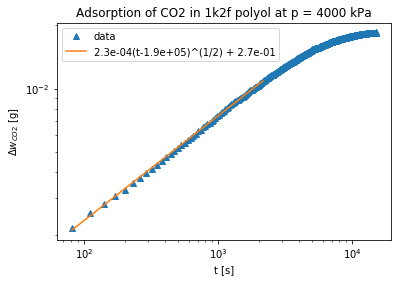

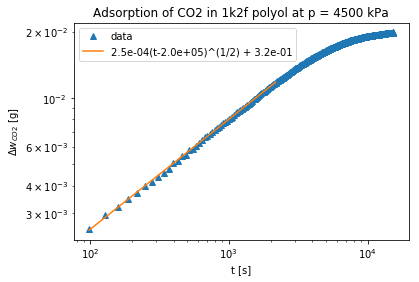

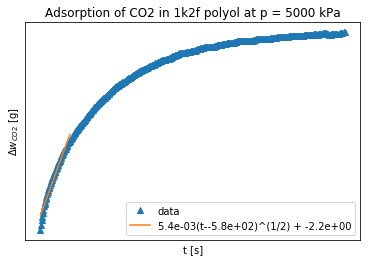

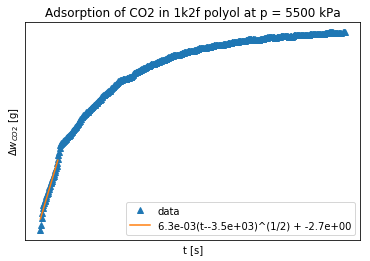

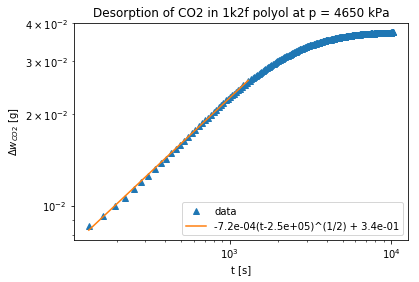

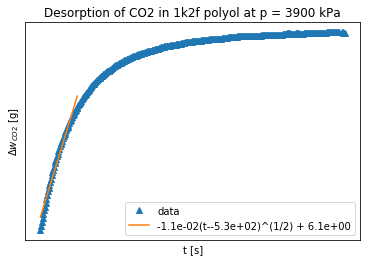

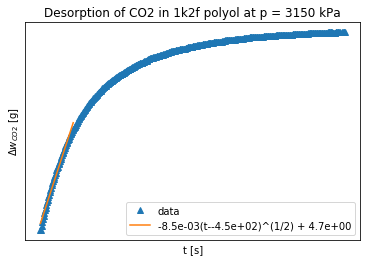

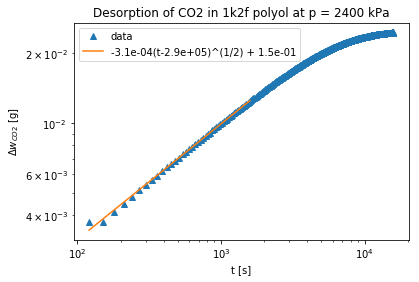

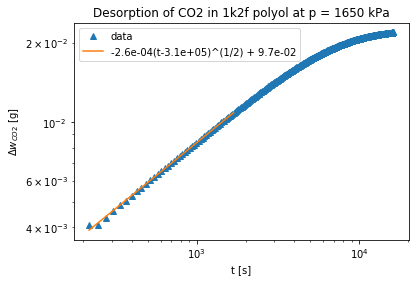

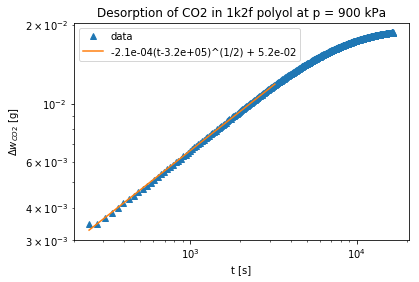

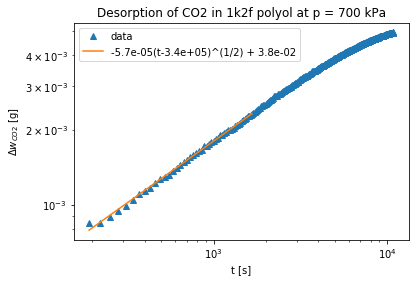

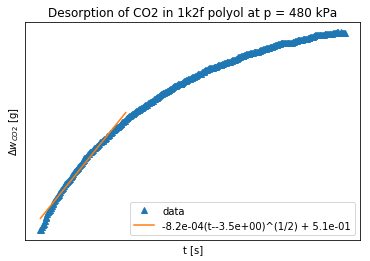

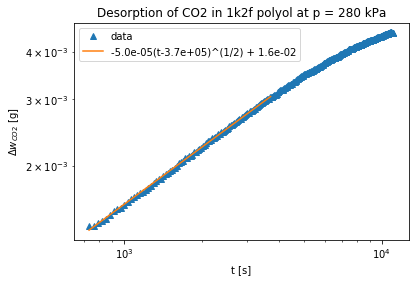

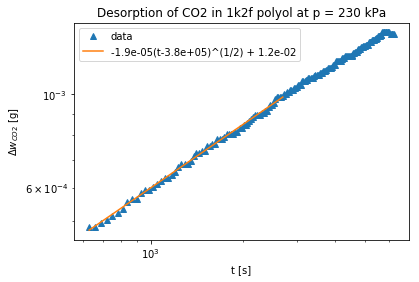

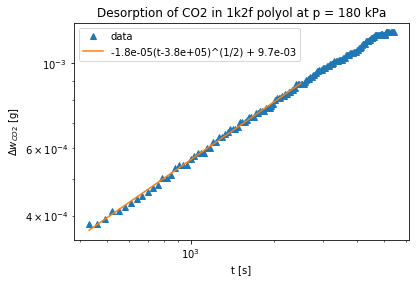

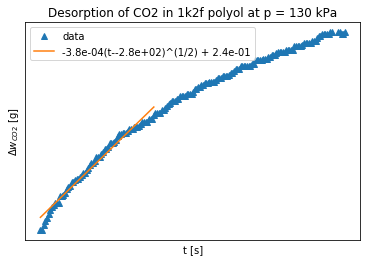

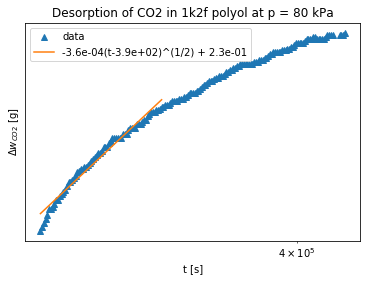

In [38]:
# NOTES
# p = 5500 kPa doesn't seem to be fit properly--should I try to refit with a different number of points (cut off before kink?)
# FOR REFERENCE
# p_set_arr = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500,
#                        5000, 5500, 4650, 3900, 3150, 2400, 1650, 900, 700, 480, 
#                        280, 230, 180, 130, 80])

# raise max number of function evaluations for fitting
maxfev = 10000
# number of data points to use for fitting to square root (beginning of curve)
n_pts_sqrt_arr = 50*np.ones(len(p_set_arr)).astype(int)
n_pts_sqrt_arr[11] = 30
n_pts_sqrt_arr[8:10] = 70
n_pts_sqrt_arr[12] = 40
n_pts_sqrt_arr[13] = 50
n_pts_sqrt_arr[17] = 100
n_pts_sqrt_arr[19] = 100
n_pts_sqrt_arr[20] = 100
n_pts_sqrt_arr[21] = 70
n_pts_sqrt_arr[22] = 70
n_pts_sqrt_arr[23] = 70
n_pts_sqrt_arr[24] = 70
# number of data points to use for fitting to exponential (end of curve)
n_pts_exp = 50
# shift in indices to cut off beginning data points that don't match t^1/2 fit
i_shift = np.zeros(len(p_set_arr)).astype(int)
i_shift[2:7] = 2
i_shift[7:10] = 3
i_shift[11:14] = 3

# initialize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_sqrt_arr = np.zeros([len(p_set_arr)])
# initialize array to store initial mass M_0 extrapolated with t^1/2 fit
M_0_extrap = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    n_pts_sqrt = n_pts_sqrt_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    # the initial time of sorption is defined as the point where the pressure began changing after the previous sorption test
    i_t0 = i_p1
    t0 = t_grav[i_t0]
    # get indices of each measurement with pressure within thresholds 
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
    t_init = t_grav[i_p0]
    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, is_adsorbing = dataproc.compute_gas_mass(i, p_arr, p_set_arr, df, bp_arr, br_arr, t_grav, 
                     p_thresh_frac, last_bound, v_ref_he)
    # update last bound with last index of current pressure run
    last_bound = i_p1
    # additional cutting off of data for t^1/2 fit
    t_mp1 = t_mp1[i_shift[i]:]
    w_gas_act = w_gas_act[i_shift[i]:]
    
    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
      
    # fit initial data points to a square root curve per eqn 10.165 in Crank (1956) "The Mathematics of Diffusion"
    n = min(n_pts_sqrt, len(t_mp1)-1)
    popt, pcov = curve_fit(dataproc.square_root_3param, t_mp1[:n], w_gas_act[:n], maxfev=maxfev)
    a = popt[0]
    w0 = popt[1]
    t0_fit = popt[2]
    # generate data points for t^(1/2) fit
    t_fit = np.linspace(t_mp1[0], t_mp1[n-1], 100)
    w_fit = dataproc.square_root_3param(t_fit, a, w0, t0_fit)
    # plot the result to examine the fit
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # plot data translated such that first point is 0,0 and data increases (so t^1/2 looks like a straight line on log-log)
    sign = 2*(is_adsorbing-0.5)
    ax.loglog(t_mp1 - t0_fit, sign*(w_gas_act - w0), '^', label='data')
    ax.loglog(t_fit - t0_fit, sign*(w_fit - w0), '-', label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=w0, t0=t0_fit))
    ax.set_xlabel('t [s]')
    ax.set_ylabel(r'$\Delta w_{CO2}$ [g]')
    if is_adsorbing:
        stage = 'Adsorption'
    else:
        stage = 'Desorption'
    ax.set_title(stage + ' of CO2 in 1k2f polyol at p = %d kPa' % p_set)
    plt.legend(loc='best')

    print('t min = {0:.3f} and t max = {1:.3f}'.format(np.min(t_mp1 - t0_fit), np.max(t_mp1 - t0_fit)))
    print('w min = {0:.3f} and w max = {1:.3f}'.format(np.min(sign*(w_gas_act - w0)), np.max(sign*(w_gas_act - w0))))
    
    # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
    D_sqrt = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df)
    print('D_sqrt = %.2e cm^2/s.' % D_sqrt)
    # store result
    D_sqrt_arr[i] = D_sqrt
    
    # Also save the "initial" mass extrapolated to the beginning of the change in pressure
    M_0_extrap[i] = dataproc.square_root_3param(max(t_init, t0_fit), a, w0, t0_fit)
    print('t_init = ' + str(t_init))
    print('t0_fit = ' + str(t0_fit))
    print('t0 = ' + str(t0))
    

#     # try a 1-parameter fit...always fails so far
#     try:
#         # really should use the beginning of the pressure change as point of t0 (indicated by the 'last_bound')
#         t0 = t_grav[last_bound]
#         # shift time and mass
#         t_rel = t_mp1 - t0
#         w_gas_act_0 = dataproc.square_root_3param(t0, a, b, t0_fit)
#         w_rel = w_gas_act - w_gas_act_0
#         # refit the shifted data
#         popt, pcov = curve_fit(dataproc.square_root_1param, t_rel, w_rel, maxfev=maxfev, p0=0.0001)
#         a1 = popt[0]
#         # generate t^(1/2) fit
#         t_fit1 = np.linspace(0, t_rel[-1], 100)
#         w_fit1 = dataproc.square_root_growth(t_fit1, a1)
#         # plot the result on a loglog plot (?)
#         fig = plt.figure()
#         ax = fig.add_subplot(111)
#         ax.plot(t_rel, w_rel, '^', label='data')
#         ax.plot(t_fit1, w_fit1, '-', label='%.1e t^(1/2)' % a1)
#         ax.set_xlabel('t [s]')
#         ax.set_ylabel(r'$\Delta w_{CO2}$ [g]')
#         if is_adsorbing:
#             stage = 'Adsorption'
#         else:
#             stage = 'Desorption'
#         ax.set_title(stage + ' of CO2 in 1k2f polyol at p = %d kPa - 1 param fit' % p_set)
#         plt.legend(loc='best')
#     except:
#         print('1 param fit failed.')

Having computed the mean diffusivities, we will save them.

In [39]:
# record diffusivity calculated using the t^(1/2) (squareroot) fit in the data frame [cm^2/s]
df['diffusivity (sqrt) [cm^2/s]'] = D_sqrt_arr
# record "initial" mass extrapolated to be at beginning of pressure quench
df['M_0 (extrap) [g]'] = M_0_extrap

# save results
df.to_csv(save_folder + save_data_name)

#### Model 2: Exponential Fit (based on equation 10.168 in section 10.6.8 of Crank, 1956)

In the later stages of diffusion, Crank demonstrates that the mass of a sample in an atmosphere of diffusing gas obeys the following equation (equation 10.168 in *The Mathematics of Diffusion*, 1956),

\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}t}\left[\log(M_t - M_{\infty})\right] &= - \frac{D \pi^2}{l^2} \\
\end{align*}

At late enough times, the concentration is close enough to the equilibrium value that the affect of the changing concentration in the system on the diffusion coefficient $D$ is negligible. Therefore, in this model, we assume that $D$ is constant and corresponds to the diffusion coefficient at the equilibrium concentration.

As above, to map this system to the present system where the sample is only exposed to gas on one surface and has a no-flux condition on the other, we replace $l$ with $2 h_{samp}$. We can then integrate the above equation to arrive at the following functional form for the mass of the sample,

\begin{align*}
M_t &= M_{\infty} - (M_{\infty} - M_0) \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\frac{M_{\infty} - M_t}{M_{\infty} - M_0} &= \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\end{align*}

where **in this case, as opposed to above for the $t^{1/2}$ fit, $M_0$ is the mass of the sample at the beginning of the exponential behavior (which we define as $t=0$).**

As noted before, $M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ is constant, it can be "absorbed" in the constant $M_{\infty}$ (so the constant term would represent the equilibrium mass of adsorbed gas rather than of the total sample mass). We can then perform a fit of the mass of adsorbed gas to the following functional form,

\begin{align*}
W_{gas}^{act} &= A \exp \left[B t\right] + C \\
\end{align*}

where $A$, $B$, and $C$ are fitting parameters. Then $C$ is the equilibrium mass of adsorbed gas $W_{gas,\infty}^{act}$ and $B$ can be related to the diffusion constant $D$ by the following equation,

\begin{align*}
D &= -\frac{4 h_{samp}^2}{\pi^2} B\\
\end{align*}

***DEMONSTRATE THAT CHANGE IN H_SAMP IS NEGLIGIBLE (HOW SMALL?)***

Pressure = 0 kPa.
Rejected 1 outliers.
Pressure = 500 kPa.
Rejected 1 outliers.
D_exp = 4.20e-06 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_exp = 5.31e-07 cm^2/s.
Pressure = 1500 kPa.
Rejected 1 outliers.
D_exp = 1.28e-06 cm^2/s.
Pressure = 2000 kPa.
Rejected 1 outliers.
D_exp = 6.18e-08 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_exp = 1.12e-06 cm^2/s.
Pressure = 3000 kPa.
Rejected 1 outliers.
D_exp = 9.89e-06 cm^2/s.
Pressure = 3500 kPa.
Rejected 1 outliers.
D_exp = 6.19e-05 cm^2/s.
Pressure = 4000 kPa.
Rejected 1 outliers.
D_exp = 7.12e-09 cm^2/s.
Pressure = 4500 kPa.
Rejected 1 outliers.
D_exp = 7.00e-06 cm^2/s.
Pressure = 5000 kPa.
Rejected 1 outliers.
D_exp = 3.01e-05 cm^2/s.
Pressure = 5500 kPa.
Rejected 1 outliers.
D_exp = 1.40e-05 cm^2/s.
Pressure = 4650 kPa.
Rejected 1 outliers.
D_exp = 4.33e-05 cm^2/s.
Pressure = 3900 kPa.
Rejected 1 outliers.
D_exp = 3.65e-09 cm^2/s.
Pressure = 3150 kPa.
Rejected 1 outliers.
D_exp = 1.37e-05 cm^2/s.
Pressure = 2400 kPa.
Rej

C:\Anaconda3\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "



Pressure = 1650 kPa.
Rejected 1 outliers.
D_exp = 5.92e-06 cm^2/s.
Pressure = 900 kPa.
Rejected 1 outliers.
D_exp = 7.32e-06 cm^2/s.
Pressure = 700 kPa.
Rejected 1 outliers.
D_exp = 1.00e-05 cm^2/s.
Pressure = 480 kPa.
Rejected 1 outliers.
D_exp = 5.77e-06 cm^2/s.
Pressure = 280 kPa.
Rejected 1 outliers.
D_exp = 5.24e-06 cm^2/s.
Pressure = 230 kPa.
Rejected 1 outliers.
D_exp = 7.70e-06 cm^2/s.
Pressure = 180 kPa.
Rejected 1 outliers.
D_exp = 9.33e-06 cm^2/s.
Pressure = 130 kPa.
Rejected 1 outliers.
D_exp = 5.08e-06 cm^2/s.
Pressure = 80 kPa.
D_exp = 9.18e-06 cm^2/s.


C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


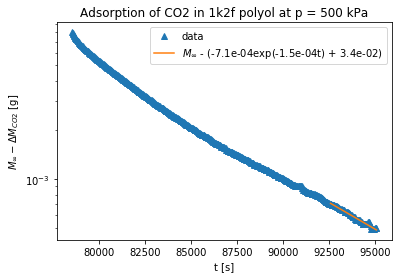

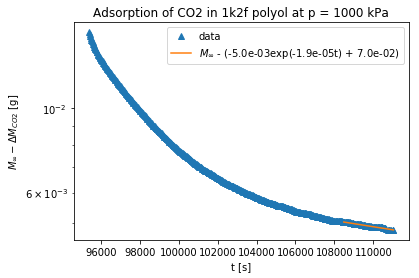

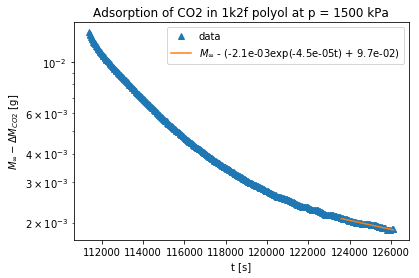

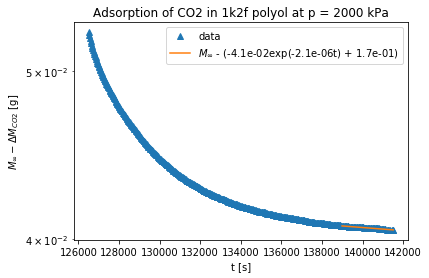

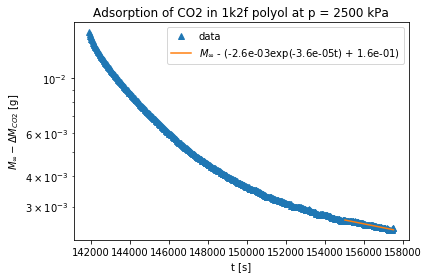

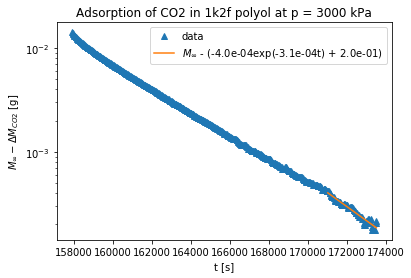

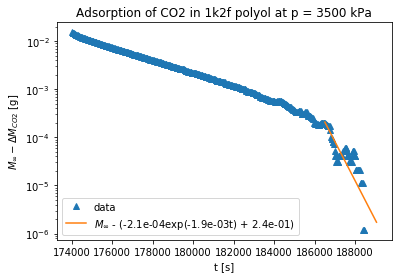

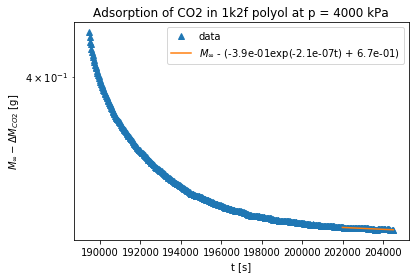

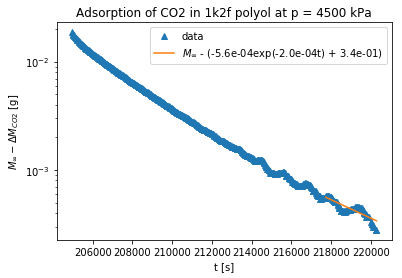

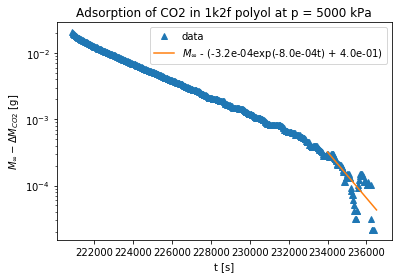

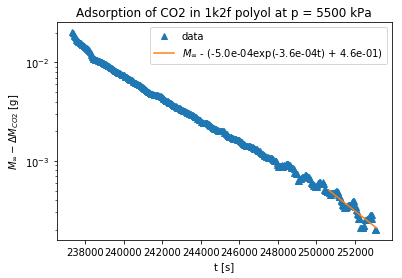

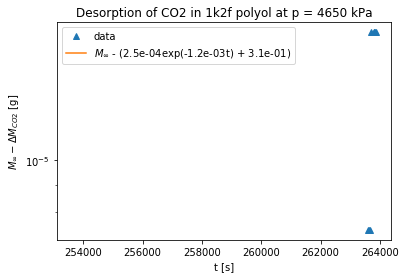

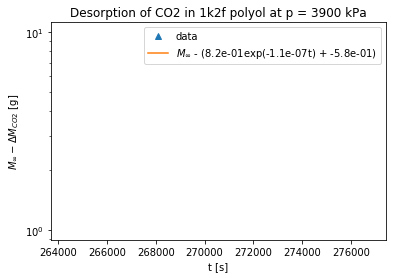

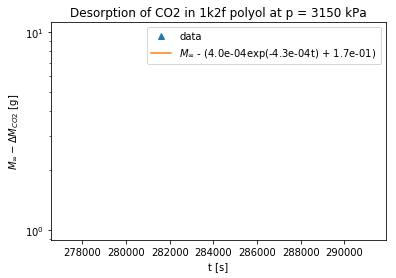

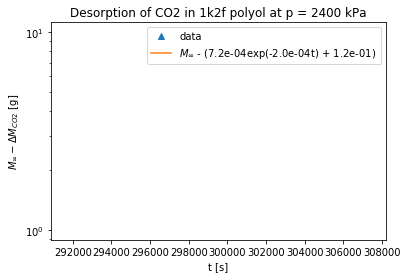

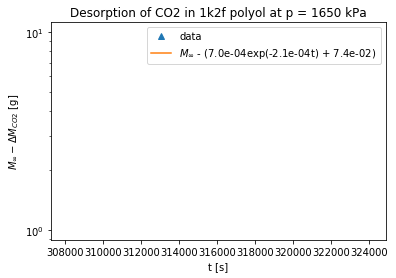

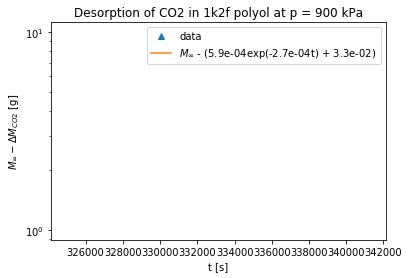

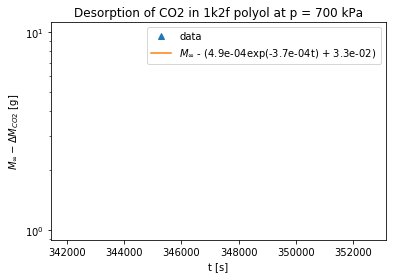

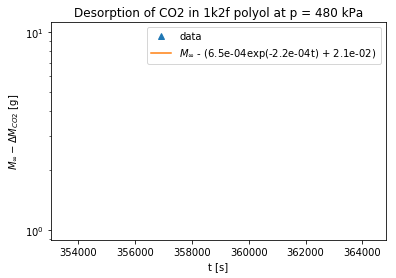

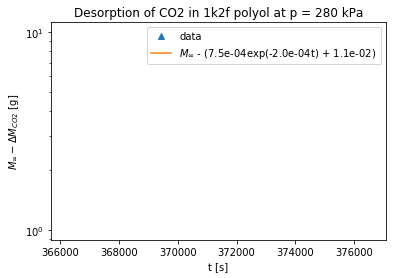

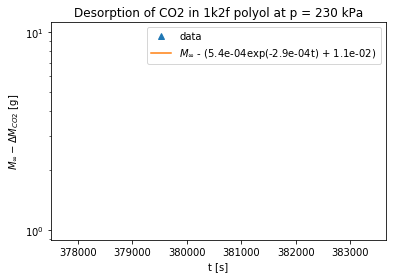

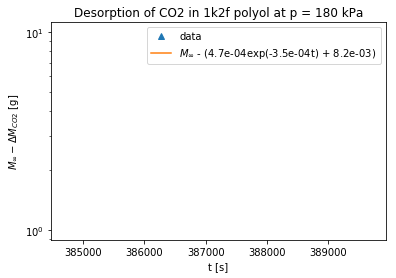

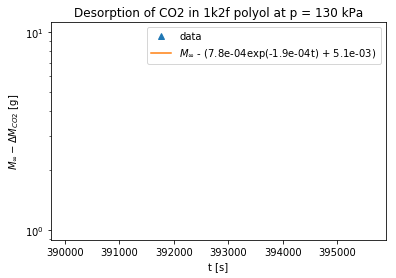

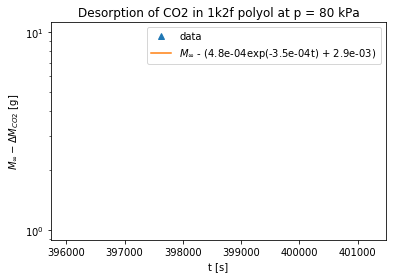

In [40]:
# initalize marker for pressure bounds
last_bound = 0
# set number of points for exponential fit
n_pts_exp = 80
# initialize array to store diffusivity values
D_exp_arr = np.zeros([len(p_set_arr)])
# initialize array of extrapolated mass at t --> infinity
M_infty_arr = np.zeros([len(p_set_arr)])
# initialize array to store fitted exponential time constants [s]
tau_arr = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, is_adsorbing = dataproc.compute_gas_mass(i, p_arr, p_set_arr, df, bp_arr, br_arr, t_grav, 
                     p_thresh_frac, last_bound, v_ref_he)
    
    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
        
    # fit initial data points to a square root curve per eqn 10.165 in Crank (1956) "The Mathematics of Diffusion"
    popt, pcov = curve_fit(dataproc.exponential_approach, t_mp1[-n_pts_exp:]-t_mp1[-n_pts_exp], w_gas_act[-n_pts_exp:], maxfev=maxfev, 
                           p0=(-0.01, -0.01, 0.1))
    a, b, c = popt
    # generate data points for exponential fit
    t_fit = np.linspace(t_mp1[-n_pts_exp], t_mp1[-1], 100) - t_mp1[-n_pts_exp]
    w_fit = dataproc.exponential_approach(t_fit, a, b, c)
    # plot the result to examine the fit
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.semilogy(t_mp1, c - w_gas_act, '^', label='data')
    ax.semilogy(t_fit + t_mp1[-n_pts_exp], c - w_fit, '-', label=r'$M_{\infty}$' + ' - ({a:.1e}exp({b:.1e}t) + {c:.1e})'.format(a=a, b=b, c=c))
    ax.set_xlabel('t [s]')
    ax.set_ylabel(r'$M_{\infty} - \Delta M_{CO2}$ [g]')
    ax.tick_params(axis='y', which='minor', left=True)
    if is_adsorbing:
        stage = 'Adsorption'
    else:
        stage = 'Desorption'
    ax.set_title(stage + ' of CO2 in 1k2f polyol at p = %d kPa' % p_set)
    plt.legend(loc='best')

    D_exp = dataproc.compute_D_exp(i, diam_cruc, df, b)
    print('D_exp = %.2e cm^2/s.' % D_exp)
    # store result
    D_exp_arr[i] = D_exp
    
    # Store mass estimated at time --> infinity
    M_infty_arr[i] = c
    # store fitted exponential time constant [s]
    tau_arr[i] = -1/b

Having computed the mean diffusivities, we will save them.

In [41]:
# record diffusivity calculated using the exponential fit in the data frame [cm^2/s]
df['diffusivity (exp) [cm^2/s]'] = D_exp_arr
# record mass extrapolated at time goes to infinity [g]
df['M_infty (extrap) [g]'] = M_infty_arr
# record fitted exponential time constant [s]
df['diffusion time constant [s]'] = tau_arr

# save results
df.to_csv(save_folder + save_data_name)